<a href="https://colab.research.google.com/github/jbuxt/GEOM180_teaching/blob/main/GEOM180_Workshop_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GEOM180 Workshop 4: Active remote sensing data and novel datasets**

In this session we will be working with other forms of remote sensing data which are grouped by three domain areas:

Arctic glacier change:

*   DEM - ice change in Arctic - October Revolution Island
*   Using Sentinel-1 to visualise this change
*   Making a composite synthetic RGB Sentinel-1 image to help visualise changes

Flooding mapping:

*   Using differences in surface roughness as measured by Sentinel-1 to map flooding
*   Measuring extent of flooding

Night time lights dataset:

*   Applying alternative datasets to assess changes in urban areas
*   Quantify one measure of recovery from hurricane damage

After this session you will also hopefully have a better idea of how to import data into GEE and to call it in as a variable with the Python API.

An additional resource which will be helpful, is the [Earth Engine API Docs page](https://developers.google.com/earth-engine/api_docs). This is a list of every GEE function (in Javascript) with a description of what the function is and what its inputs should be. This is super helpful if you're trying to work out whether the function you want to use is for an Image or ImageCollection or if you can't remember the arguments for a function.

Any questions, just ask Josh, Joseph or Steve during the session, or email Josh on j.buxton@exeter.ac.uk.

Workshop date: 27th November 2023

Next week: Mapping and presenting data, and time to work on coursework.


# **Task 1: Import initial package and validate Google Earth Engine connection.**

As with the last workshop, these steps are required to connect to Google Earth Engine. You will need to do this everytime you load up Earth Engine!

In [ ]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

EEException: Google Earth Engine API has not been used in project 522309567947 before or it is disabled. Enable it by visiting https://console.developers.google.com/apis/api/earthengine.googleapis.com/overview?project=522309567947 then retry. If you enabled this API recently, wait a few minutes for the action to propagate to our systems and retry.

In [ ]:
import geemap

import os
from geemap.conversion import *

# **Task 2: Connect Google Drive to Colab**

In order to easily access your files which are stored in Google Drive, you should mount Google Drive in colab environment.

In the navigation bar on the left of the screen, click the "Files" button. This will open up a panel which allows you to view all of your files. At the top are four buttons, one of which has the Google Drive logo on it. Click this to mount Google Drive, this will then add a drive folder to the files list.

Alternatively you can do this with the code provided below.

In [ ]:
#Use this code to connect between Google Drive and this colab document.

from google.colab import drive
drive.mount('/content/drive')

# **Task 3: Use a DEM to observe changes in an Arctic glacier**

This first task is to see how Digital Elevation Models (DEM) can be used to monitor changes in the cryosphere. As the name suggests, these DEMs give an indication of landscape elevation.

Located in the Arctic, October Revolution Island has several large domed glaciers which reach down to the sea. In 2015 and 2016, one of these glaciers underwent noticeably accelerated warming, with the glacier front advancing on the west side.

One DEM dataset which covers this region is the [ArcticDEM](https://www.pgc.umn.edu/data/arcticdem/). This is formed from large strips which are measured at different points in time. While areas do have multiple data points at different points in time, this does not occur with regularity and varies across the Arctic. There is also a composite mosaic which is formed from different time points to create a spatially complete image of the Arctic.

We will use the strip data below from [GEE](https://developers.google.com/earth-engine/datasets/catalog/UMN_PGC_ArcticDEM_V3_2m) and will filter the data into before 2015 and after 2015 to visualise any changes.

In [ ]:
#First define our region of interest in order to filter data

arctic_roi = ee.Geometry.Point([95.54,79.34])

In [ ]:
#Here we filter our ImageCollection into two different time periods

dem_dataset_before = ee.ImageCollection('UMN/PGC/ArcticDEM/V3/2m').filterBounds(arctic_roi)\
.filterDate('2008-08-01','2015-01-01')

dem_dataset_after = ee.ImageCollection('UMN/PGC/ArcticDEM/V3/2m').filterBounds(arctic_roi)\
.filterDate('2015-01-01','2017-01-01')

elevation_before = dem_dataset_before.select('elevation').mean()                  #We create an average 'before' and 'after' image
elevation_after = dem_dataset_after.select('elevation').mean()

elevation_vis = {
  'min': -50,
  'max': 1000,
  'palette': ['0d13d8', '60e1ff', 'ffffff'],
}

Map = geemap.Map()
Map.add('layer_manager')
Map.add_basemap('HYBRID')                   #For visualisation ease, I have added a satellite basemap as well. This is a composite and does not have a date associated with it.
Map.add_layer(elevation_before, elevation_vis, 'Elevation before')
Map.add_layer(elevation_after, elevation_vis, 'Elevation after')
Map.centerObject(arctic_roi,8)
Map.add_layer(arctic_roi,{'color':'ff0000'},'Arctic ROI')
Map
#display(dem_dataset)

Map(center=[79.34, 95.54000000000002], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=…

# **Task 4: Use Sentinel-1 data to monitor changes in an Arctic glacier**

Sentinel-1 SAR data provides another way to visualise changes in high latitude glaciers.

This is an 'active' remote sensing dataset, which will allow us to monitor changes in the 'roughness' of the surface.

*High latitude active satellite use*

For large parts of the year, high latitude sites experience little to no daylight. This makes it very difficult to measure landscape change with passive sensor data. However active sensors, such as Sentinel-1, are capable of taking measurements all year round.

*Backscatter coefficient*

The 'backscatter coefficient' gives a measure of how much energy has been reflected from the Earth's surface back at the satellite. For example, a with a smooth surface, such as still water bodies, the angle of reflectence is the same as the angle of incidence, so the signal is not returned to the satellite. While a rougher surface will scatter the signal, thus allowing some of it to be detected by the sensor.




In [ ]:
def mask_edge(image):
  edge = image.lt(-30.0)
  masked_image = image.mask().And(edge.Not())
  return image.updateMask(masked_image)


img_vv = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    .select('VV')
    .map(mask_edge)
)

first_img = img_vv.filter(ee.Filter.date('2015-04-01', '2015-04-20')).mean()
second_img = img_vv.filter(ee.Filter.date('2015-11-01', '2015-11-20')).mean()
third_img = img_vv.filter(ee.Filter.date('2016-08-01', '2016-08-20')).mean()

Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.add('Layer_manager')
Map.centerObject(arctic_roi,8)
Map.add_layer(elevation_before, elevation_vis, 'Elevation before')
Map.add_layer(elevation_after, elevation_vis, 'Elevation after')
Map.add_layer(first_img, {'min':-25,'max':5},'First img')
Map.add_layer(second_img, {'min':-25,'max':5},'Second img')
Map.add_layer(third_img, {'min':-25,'max':5},'Third img')
Map.add_layer(arctic_roi,{},'Arctic ROI')
Map

Map(center=[79.34, 95.54000000000002], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=…

*How does the Sentinel-1 SAR data add to our knowledge from the DEM image?*

*What limitations are there for the time period that we have chosen for this study?*

*Why does the third image look so different to the image 1 and 2?*

**Create a synthetic RGB image from SAR data**

RGB images are formed from three bands - red, green and blue. It is possible to create multi-band images where each band corresponds to a different point in time, rather than a different section of the electromagnetic spectrum.

Here we will create a synthetic RGB image for a given time frame from SAR data, each band corresponds to a different time period. This can be a quick way to assess which parts of the landscape have changed over this time. Regions that have undergone change will show up as certain colours, whereas white regions have shown little or no change.

In [ ]:
#We will use only images that are from the descending pass of Sentinel-1

desc = img_vv.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))

#Here we filter them into different time periods
spring = desc.filter(ee.Filter.date('2017-03-01', '2017-04-20'));
lateSpring = desc.filter(ee.Filter.date('2017-04-21', '2017-06-10'));
summer = desc.filter(ee.Filter.date('2017-06-11', '2017-08-31'));

#We take the mean of each time period and then concatenate them into a single image
#Here each band of the image is formed from one image
change = ee.Image.cat(
    spring.mean(),
    lateSpring.mean(),
    summer.mean());

Map.add('Layer_manager')
Map.add_layer(change, {'min': -25, 'max': 5}, 'Multi-T Mean DESC');
Map



*What does the synthetic-RGB composite tell us about changes within a season?*

**InSAR**

Another useful application for Sentinel-1 (which is sadly not possible with GEE) is Interferometry (known as InSAR).

This technique uses phase information to measure the distance between the satellite sensor and the land surface. With this knowledge, one can use the difference between two different Sentinel-1 signals to measure changes in land surface topography.

This is useful for detecting landscape deformation following earthquakes, or in our case it could be used to detect ice loss.

More information is available on the [USGS website](https://www.usgs.gov/programs/VHP/insar-satellite-based-technique-captures-overall-deformation-picture).


# **Task 5: Apply Sentinel-1 data to map a flood**


As discussed above, the backscattering coefficient from Sentinel-1 SAR data we can measure the 'roughness' of a pixel, as this corresponds to the intensity of the microwave signal received back by the satellite.

Another application for this data is to detect and measure flooding events. This is due to the fact that still water shows a different backscattering coefficient to dry land cover.

**Case study: Kakhovka Dam**

As part of the ongoing conflict in Ukraine, on 6th June 2023 the Kakhovka Dam was destroyed by Russian forces, thus causing a large flow of water from the Kakhovka resevoir.

Work through the code below to see how Sentinel-1 data can be used to measure flooded area extent. This is done for one point in time, afterwards try the same for a later image and compare the two.

This same methodology can be applied to other, environmental, flooding events, such as hurricane-induced flooding.


In [ ]:
#We define our Region of Interest

dam_roi = ee.Geometry.Point([33.246936,46.774588])

In [ ]:
#This is an adapted version of the standard GEE code for importing and working with S1 data

def mask_edge(image):
  edge = image.lt(-30.0)
  masked_image = image.mask().And(edge.Not())
  return image.updateMask(masked_image)


#This code calls in the S1 ImageCollection
S1_vv = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))          #S1 images are polarised - vertical or horizontal. VV here are vertical for transmission and reception
    .filter(ee.Filter.eq('instrumentMode', 'IW'))                                     #Select Interferometric Wide Swath - this is the standard acquisation mode over land
    .filterBounds(dam_roi)
    .select('VV')
    .map(mask_edge)
)

#Here we filter the ccollection into two different time periods
S1_vv_baseline = S1_vv.filter(ee.Filter.date('2023-05-01','2023-05-31'))
S1_vv_baseline_composite = S1_vv_baseline.median()
S1_vv_flood = S1_vv.filter(ee.Filter.date('2023-06-06','2023-06-20'))


Map = geemap.Map()
Map.add('Layer_manager')
Map.centerObject(dam_roi,8)
Map.add_layer(S1_vv_baseline.mean(),{'min': -50, 'max': 5},'Baseline',True)
Map.add_layer(S1_vv_flood.mean(),{'min': -50, 'max': 5},'Flood',True)
Map.add_layer(dam_roi,{'color':'ff0000'},'ROI')
Map
#display(S1_vv_flood.first().date())         #Show date of first Image in Collection

*Look at the baseline layer and the flood layer, what differences do you see?*

*Think about the way that Sentinel-1 SAR data is collected, why might we be observing these differences?*

*What is the date of the first image in the 'flooded' collection? Why might this cause issues when mapping the peak of the flood extent?*

Now we will calculate the changes in surface roughness to approximate the flooding area.

In [ ]:
#Sentinel-1 images can be reduced in quality due to interference, known as speckle noise.
#The effects of this can be mitigated by applying some spatial statistical filter
#One very simple way to do this is to take an average around each pixel, which we will do here
#Other ways include calculating a Lee speckle filter

radius = 30
sample_image = S1_vv_baseline.first()
sample_image_smoothed = sample_image.focalMedian(radius,'circle','meters')


Map = geemap.Map()
Map.add('Layer_manager')
Map.centerObject(dam_roi,8)
Map.add_layer(sample_image,{'min': -50, 'max': 5},'Before Smoothing',True)
Map.add_layer(sample_image_smoothed,{'min': -50, 'max': 5},'After Smoothing',True)

Map


*For those who are interested in other forms of filtering, [here is a link](https://code.earthengine.google.com/2ef38463ebaf5ae133a478f173fd0ab5) to a GEE Javascript implementation of a Lee speckle filter*

In [ ]:
#We will apply our smoothing to all images in our study area

def spatial_smoother(image):
  radius = 30
  image_smoothed = image.focalMedian(radius,'circle','meters')
  return image_smoothed


S1_vv_baseline_composite = S1_vv_baseline_composite.focalMedian(radius,'circle','meters')     #This is a single image, so we can apply the spatial smoother directly
S1_vv_flood = S1_vv_flood.map(spatial_smoother)                                               #This is a collection, so we must map the spatial smoother over every image

#We can calculate the difference in the backscatter coefficient between these time periods
diff = S1_vv_flood.first().subtract(S1_vv_baseline_composite)


#We have to choose a threshold to distinguish between flooded and non-flooded pixels
#The one given below is somewhat arbitrary and has been chosen through trial and error
#The threshold will change depending on the flood and the images, and there are more robust ways to calculate this (see below if interested)
threshold = -4;

flood_diff_thresholded = diff.lt(threshold);

#We can then turn this into a binary image with only flooded pixels shown
flood_binary = diff_thresholded.updateMask(diff_thresholded)

Map = geemap.Map()
Map.add('Layer_manager')
Map.centerObject(dam_roi,8)
Map.addLayer(S1_vv_baseline_composite, {'min':-50,'max':5}, 'Baseline');
Map.addLayer(S1_vv_flood, {'min':-50,'max':5}, 'Flood');
Map.addLayer(diff, {'min':-10,'max':10}, 'diff');
Map.addLayer(flood_binary, {'palette':"0000FF"},'flooded areas - blue')
Map
#display(S1_vv_flood)

Map(center=[46.774588, 33.246936000000005], controls=(WidgetControl(options=['position', 'transparent_bg'], wi…

*What do you notice about the flood extent which is shown on the map?*

*Is this likely to be a true representation of the total flooded area?*

*Why are some areas away from the river shown as having flooded values?*

*For those who are interested in different thresholding values, one way is the Otsu method, for which the code is given below.*

# **Task 6: Measure extent of flooding**

We can use our flooded dataset to calculate the total area which is flooded in our image. Before we do this, we will implement a couple more steps to filter out unwanted values.

First, we will remove areas which are usually bodied of water. To do this, we will use the [JRC Global Surface Water Map](https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_4_GlobalSurfaceWater#bands), which allows us to filter out pixels where water is present for a certain number of months in the year.

Then we will filter out some of the noise where we have isolated pixels presenting as flooded pixels. To do this, we measure the connectivity of pixels and filter out isolated pixels.

In [ ]:
#We will filter out any pixel which is usually a body of water
#For this we will use a pre-existing map of water coverage

water_coverage = ee.Image('JRC/GSW1_0/GlobalSurfaceWater').select('seasonality');
water_coverage_mask = water_coverage.gte(12).updateMask(water_coverage.gte(12));

#Any area where there is water coverage every month of the year is assigned a 0 value
flooded_mask = flood_binary.where(water_coverage_mask,0);
#We then mask out these pixels
flooded = flooded_mask.updateMask(flooded_mask);

In [ ]:
#We can also see that there is some noise in the image, with isolated pixels showing up as flooded.
#We may only want to include pixels which are connected to others

connected_pixels = flooded.connectedPixelCount()
flooded_updated = flooded.updateMask(connected_pixels.gte(6))

Map.addLayer(flooded_updated, {'palette':"008cff"},'flooded areas updated - blue')
Map


*What differences do you notice between the layers?*

*Are there any other filtering steps you would want to implement?*

*Why do some pixels far away from the river still show signs of flooding? Do we believe that this is accurate or not?*

Here you are required to import shapefile data that you have uploaded as an asset. This uploading step must be done with the Javascript API, by clicking "Assets" > "New" > "Shapefile" and then uploading the data.

Visual instructions for this can be found in the slides uploaded for this week.

You will need to replace the asset ID in the code below with the asset ID for your own data.

In [ ]:
#We need to define an area to calculate the flood extent over
#For simplicity we will use some of the existing Ukrainian administrative borders
#But you may wish to find or draw a smaller area around the river
#Import Kherson region of interest shapefile

Flood_ROI = ee.FeatureCollection('projects/ee-joshuabuxton2018/assets/Kherson_ROI')               #You will need to uplod this yourself

Map.addLayer(Flood_ROI,{'color':'ff0000'},'Flood ROI')
Map

*You will notice that I have drawn a rather crude outline to create our region of interest. This is not necessarily best practice, and in your own work I'd encourage you to use sensible shapefiles, such as city administrative boundaries. The reason I have used this here is that the size of the districts that are flooded and the high resolution of our data, means that GEE kept crashing when creating this practical, so I have resorted to drawing a smaller, more focused area.*

In [ ]:
#We will now sum the number of flooded pixels in our flood image

area = ee.Image.pixelArea()
flooded_area = flooded_updated.multiply(area).rename('flooded_area')
#flooded_pixel_area = flooded_updated.select('VH').multiply(ee.Image.pixelArea())

display(flooded_area)

flood_stats = flooded_area.clip(Flood_ROI).reduceRegion(**{
    'reducer': ee.Reducer.sum(),
    'geometry': Flood_ROI.geometry(),
    'scale':10,
    'maxPixels': 1e10
})

#We can then display this value (in meters squared)
display(flood_stats.getInfo())

#Or convert it to km squared
flooded_area_km = flood_stats.getNumber('flooded_area').divide(1000000)

display(flooded_area_km)

{'flooded_area': 325187296.3689011}

*Does this represent the full extent of flood damage from this event? Why or why not?*

*What temporal/spatial factors may not be captured by the number given here?*

*While areas downstream of the dam experienced flooding damage, what issues may regions upstream of the dam have faced? How might you measure these with remote sensing data?*

# **Extra code: Creating custom geometries and exporting them**

If you want to create your own geometries and then export them to Google Drive, here is the code below to do this.

You may find this useful if you need to reduce the size or to draw a custom region of interest.

In [ ]:
#It is possible to draw geometries directly onto the map
#Here we save the last drawn geometry as a variable

ROI = Map.draw_last_feature

#Check in the variable list on the left to see if it has appeared
#Alternatively, by displaying it, we can check that it has the coordinates that we would expect it to
display(ROI)


In [ ]:
#If we want to use these geometries again, we can conver them to a FeatureCollection
#Then we can export them to Google Drive

task = ee.batch.Export.table.toDrive(
    collection=ee.FeatureCollection(ROI),
    description='Kherson_ROI',
    folder='shapefile_exports',
    fileFormat='SHP'
)

task.start()

## get the status of task while it runs every 30 sec
import time
while task.active():
    time.sleep(30)
    display(task.status())

*Note: It is also possible to check the status of this with the Javascript API, which has a useful 'Task Manager'.*

# **Task 7: Repeat for another point in time**

You may have noticed that the post-flooding dataset that we selected has multiple images in. We chose the first image in order to get as close to the dam explosion as possible.

Repeat the code above but for one of the later images, as this will give an indication of how the flood extent has changed over time.

# **Optional task: Determining the threshold for flood vs non-flood pixels**

One algorithmic way to determine the threshold in an image between two values is Otsu's method. This is a standard image processing algorithm, and isn't unique to remote sensing science.

You are not expected to understand algorithms like this, but I have provided the code below in case it is of interest.

Esentially, Otsu's method iterates through all potential threshold values to seperate the image pixels into two classes. It then finds the one where the variance between the two classes is maximised, or the variance within classes is minimised.

In [ ]:
S1_difference = S1_vv_flood.first().subtract(S1_vv_baseline_composite)

In [ ]:
#Here we calculate a histogram of the pixel values in the flooded image

histogram = S1_difference.select('VV').reduceRegion(**{
  'reducer': ee.Reducer.histogram(255, 2) \
      .combine('mean', None, True) \
      .combine('variance', None, True),
  'geometry': Flood_ROI.geometry(),
  'scale': 30,
  'bestEffort': True
})
display(histogram)

In [ ]:
# Otsu Algorithm
def otsu(histogram):
  counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
  means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
  size = means.length().get([0])
  total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
  sum = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
  mean = sum.divide(total)

  indices = ee.List.sequence(1, size)

  # Compute between sum of squares, where each mean partitions the data.

  def func_zfe(i):
      aCounts = counts.slice(0, 0, i)
      aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
      aMeans = means.slice(0, 0, i)
      aMean = aMeans.multiply(aCounts) \
          .reduce(ee.Reducer.sum(), [0]).get([0]) \
          .divide(aCount)
      bCount = total.subtract(aCount)
      bMean = sum.subtract(aCount.multiply(aMean)).divide(bCount)
      return aCount.multiply(aMean.subtract(mean).pow(2)).add(
             bCount.multiply(bMean.subtract(mean).pow(2)))

  bss = indices.map(func_zfe)

  #print(ui.Chart.array.values(ee.Array(bss), 0, means))
  # Return the mean value corresponding to the maximum BSS.
  return means.sort(bss).get([-1])

threshold = otsu(histogram.get('VV_histogram'))
display(histogram)
display('Threshold:',threshold.getInfo())


'Threshold'

-4.940705190618084

# **Task 8: Use additional datasets to monitor humanitarian crisis**

The final exercise of this workshop is to apply a novel remote sensing dataset to map changes in urban landscapes.

For this we will use the Visible Infared Radiometer Suite (VIIRS), also known as the NASA [Black Marble](https://blackmarble.gsfc.nasa.gov/). This is a daily dataset of night time light activity, which is corrected for atmospheric and terrain interference. This is a passive remote sensing dataset.

Work through the code below, there is one quick example from the current conflict in Gaza of how clear the change in night time light coverage can be and another example from hurricane damage in Puerto Rico.

In [ ]:

dataset = ee.ImageCollection('NOAA/VIIRS/001/VNP46A2')

#Bidirectional Reflectance Distribution Function (BRDF)
#This is a measure of how much light has been measured by the sensor
brdf = dataset.select('DNB_BRDF_Corrected_NTL')
brdfVis = {
  'min': 0,
  'max': 100,
  'palette': ['black', 'purple', 'cyan', 'green', 'yellow', 'red', 'white'],
}

#Map = geemap.Map()
#Map.add('Layer_manager')
#Map.addLayer(brdf, brdfVis, 'DNB_BRDF_Corrected_NTL')
#Map

Here again you will need to import your own vector data asset in from GEE. Instructions for this are provided above in the flood extent task or also in the slides uploaded for this practical.

In [ ]:
#Import Gaza Shapefile
#You will need to change the file path to your own directory for this
gaza_border = ee.FeatureCollection('projects/ee-joshuabuxton2018/assets/GazaStrip_MunicipalBoundaries')

In [ ]:
dataset = ee.ImageCollection('NOAA/VIIRS/001/VNP46A2')

# Bidirectional Reflectance Distribution Function (BRDF)
#This is a measure of how much light has been measured by the sensor
brdf = dataset.select('DNB_BRDF_Corrected_NTL')
brdfVis = {
  'min': 0,
  'max': 100,
  'palette': ['black', 'purple', 'cyan', 'green', 'yellow', 'red', 'white'],
}

gaza_brdf_before = brdf.filter(ee.Filter.date('2023-08-01', '2023-09-30')).mean()
gaza_brdf_after = brdf.filter(ee.Filter.date('2023-10-10', '2023-10-20')).mean()

brdf_whole = brdf.filter(ee.Filter.date('2021-01-01', '2021-02-28'))

# Day/Night Band (DNB)
# NightTime Light (NTL)
Map = geemap.Map()
Map.add('Layer_manager')
Map.addLayer(gaza_brdf_before.clip(gaza_border), brdfVis, 'DNB_BRDF_Corrected_NTL_before')
Map.addLayer(gaza_brdf_after.clip(gaza_border), brdfVis, 'DNB_BRDF_Corrected_NTL_during')
Map.addLayer(gaza_border,{'color':'ff0000'},'Gaza Border')
Map.centerObject(gaza_border,8)
#Map.addLayer(brdf_whole, brdfVis, 'DNB_BRDF_Corrected_NTL_whole')

Map

Map(center=[31.406190694626453, 34.37718810493112], controls=(WidgetControl(options=['position', 'transparent_…

*You can also use the `.buffer()` function to enlarge the size of the study area. If you do this for the Gaza border shapefile, you may also see the effects of the evacuation of Israeli settlements near to Gaza. Alternatively, you can remove the `.clip()` function to add the whole of the ImageCollection to the map, this will also allow you to view areas outside of our region of interest.*

*Which areas in the region still show measureable levels of night time lights?*

# **Task 9: Apply same VIIRS dataset to assess infrastructure damage from a hurricane**

In September 2017, Puerto Rico was hit by Hurricane Maria, which became the deadliest and one of the most damaging hurricanes to hit the island. Recovery from this was notable due to the delays in funding from the federal government and general criticism of the US response to the crisis.

Use the code below to visualise spatially and temporally how the hurricane affected the night time light levels in the capital city of San Juan.

Think about what these night time light levels may be a proxy for and what additional information they can give us about the resilience of local infrastructure and recovery.

In [ ]:
dataset = ee.ImageCollection('NOAA/VIIRS/001/VNP46A2')

# Bidirectional Reflectance Distribution Function (BRDF)
brdf = dataset.select('DNB_BRDF_Corrected_NTL')
brdfVis = {
  'min': 0,
  'max': 100,
  'palette': ['black', 'purple', 'cyan', 'green', 'yellow', 'red', 'white'],
}

brdf_baseline = brdf.filter(ee.Filter.date('2017-01-01', '2017-08-31'))
brdf_during = brdf.filter(ee.Filter.date('2017-09-25', '2017-09-30'))

#Map.addLayer(brdf_whole, brdfVis, 'DNB_BRDF_Corrected_NTL_whole')

FAO_borders = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

puerto_rico = FAO_borders.filter(ee.Filter.eq('ADM0_NAME','Puerto Rico'))
Bayamon = puerto_rico.filter(ee.Filter.eq('ADM1_NAME','Bayamon')).geometry()
san_juan = puerto_rico.filter(ee.Filter.eq('ADM1_NAME','San Juan')).geometry()

sj_roi = Bayamon.union(san_juan)


# Day/Night Band (DNB)
# NightTime Light (NTL)
Map = geemap.Map()
Map.add('Layer_manager')
Map.addLayer(brdf_baseline, brdfVis, 'DNB_BRDF_Corrected_NTL_before')
Map.addLayer(brdf_during, brdfVis, 'DNB_BRDF_Corrected_NTL_during')
Map.addLayer(sj_roi,{'color':'ff0000'},'San Juan')
Map.centerObject(sj_roi,8)

Map

Now we will map the differences in light level across a couple of different time periods.

It is important to think about what limitations this approach might have - changes from day to day can be effected by noise, missing data during these periods, or some element of seasonality.

In [ ]:
#We define three periods of time - a baseline, 1 week from the start of the storm, and then a month afterwards

brdf_baseline = brdf.filter(ee.Filter.date('2017-01-01', '2017-08-31'))
brdf_week1 = brdf.filter(ee.Filter.date('2017-09-25', '2017-10-02'))
brdf_week2 = brdf.filter(ee.Filter.date('2017-10-03', '2017-10-31'))


#Take the average of these ImageCollections and then clip them just to our study area
sj_brdf_baseline = brdf_baseline.mean().clip(sj_roi)
sj_brdf_week1 = brdf_week1.mean().clip(sj_roi)
sj_brdf_week2 = brdf_week2.mean().clip(sj_roi)

#Calculate the difference between the baseline and after the storm
brdf_week1_diff = sj_brdf_week1.subtract(sj_brdf_baseline)
brdf_week2_diff = sj_brdf_week2.subtract(sj_brdf_baseline)

#Create a visualisation palette from red (negative change) to white (no change)
diffVis = {
  'min': -100,
  'max': 0,
  'palette': ['ff0000','ffffff'],
}

Map.addLayer(brdf_week1_diff.clip(sj_roi),diffVis,'Week 1 Diff')
Map.addLayer(brdf_week2_diff.clip(sj_roi),diffVis,'Week 2 Diff')
Map

*Compare the two time periods that we have considered. What can they tell us about nighttime activity in San Juan immediately after the hurricane?*

*Is there much recovery in the month after the hurricane? What might this tell us about infrastructure in the area?*

# **Task 10: Use the same dataset to measure recovery**

We might be interested in looking at how the trends in night time lights change after an environmental disasters. This could be used as a proxy for the resilience of the local energy grid and the ability of regions to recover from disasters.

Above we have plotted this spatially, now we will plot this over time. We will use the same dataset imported above, and will use the whole duration of it. This will allow us to get an idea of the noise level in the data and whether the changes that we have mapped above are clear, distinct events.

The method for doing this is the same as the time series that we made last week, but we will be using different datasets and a different spatial area.

In [ ]:
#Import new Python packages

import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
#Create a function to calculate the spatial mean for our study area for each image in the collection
def average_light(img):
  mean_brdf = img.reduceRegion(reducer=ee.Reducer.mean(),geometry=sj_roi,scale=500).get('DNB_BRDF_Corrected_NTL')
  return img.set('brdf_mean',mean_brdf)


average_light_reduced = dataset.map(average_light)

#display(average_light_reduced)

light_nested_list = average_light_reduced.reduceColumns(ee.Reducer.toList(2), ['system:time_start'.format("yyyy-MM-dd"),'brdf_mean']).values().get(0)

display(light_nested_list)



In [ ]:
#We must convert this into a dataframe

df_light = pd.DataFrame(light_nested_list.getInfo(), columns=['system:time_start','brdf_mean'])

#If we want to have the "time_start" in a more readable form
#We can convert this with the to_datetime command and add this date as an extra olumn

df_light['date'] = pd.to_datetime(df_light['system:time_start'],unit='ms').dt.date

#Note the extra ".dt.date" command removes the time component of the date

#We can also calculate a rolling average to help smooth out noise in our time series
#To do this we use the .rolling(window).mean() command
#We will use a window of 7 (days) to start with
window_size = 7
df_light['brdf_ma'] = df_light['brdf_mean'].rolling(window_size).mean()

#To make it easier to plot, we will create a new dataframe and remove the system:time_start column
#As we have converted this into a readable date component
old_df_light = df_light
df_light = df_light.drop('system:time_start', axis=1)


display(df_light)

,brdf_mean,date,brdf_ma
0,21.979089,2012-01-19,NaN
1,20.101948,2012-01-20,NaN
2,16.908920,2012-01-21,NaN
3,18.124051,2012-01-22,NaN
4,25.578195,2012-01-23,NaN
...,...,...,...
3915,18.602675,2023-11-10,18.853254
3916,33.174666,2023-11-11,21.208773
3917,19.309941,2023-11-12,21.530982
3918,19.809622,2023-11-13,21.486827


Text(0.5, 0, 'Date')

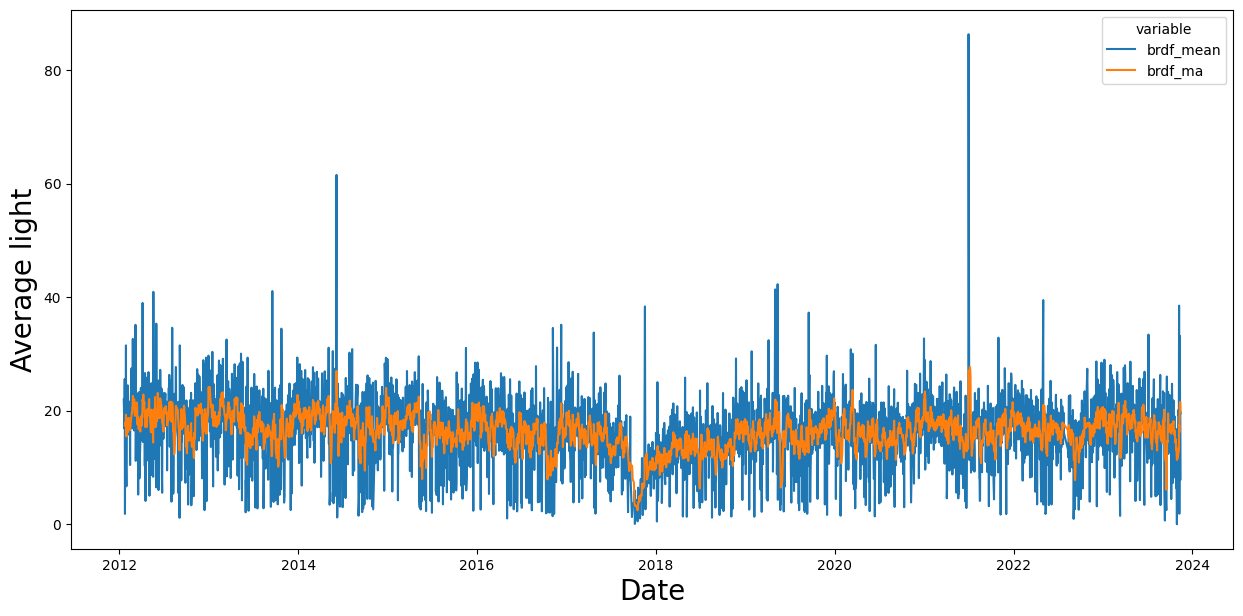

In [ ]:
# We can define an initial figure with dimensions of 15 x 7
fig, ax = plt.subplots(figsize=(15,7))

# We can then use seaborn lineplot to make the figure
# Here our data argument is our initial dataframe, and we select two of the columns as the x and y values
sns.lineplot(data=pd.melt(df_light,['date']), x="date",y='value',hue='variable')


# We can then set the labels and title
ax.set_ylabel('Average light',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
#ax.set_title('S2 NDVI Values for ROI');


*What can we learn by looking at the time series above? Just by inspecting the time series, can you identify when the hurricane hit Puerto Rico?*

*What is the recovery timescale from this disaster? How would you measure it?*

*What is the recovery from this disaster like across different times, such as weeks, months, years?*

*What other datasets could you combine with this to develop a richer understanding of the impact of this hurricane on the local population?*

# **Additional Tasks**

Above we have gone through examples of using Sentinel-1 to map flooding and night time light data to detect the impact of hurricanes.

If you have time would recommend that you now do one (or both) of the following:

1.   Utilise the flood detection in a different region. Some hurricanes, such as the one in Puerto Rico, cause flooding. See if you can detect any of this fooding with Sentinel-1 data.
2.   Apply the nighttime lights data to other large scale changes. These can be of an environmental or huminatarian nature - such as infrastructure damage from earthquakes or conflict or increase in urban density from refugees, or try to map out where population centres match natural factors (i.e. take a look at light intensity in Egypt).



# **Extra code: Javascript to Python code conversion:**

In [ ]:

js_code =  """

"""

In [ ]:
#Here extract the new python code and print it

lines = geemap.js_snippet_to_py(
    js_code, add_new_cell=False, import_ee=False, import_geemap=False, show_map=True
)

for line in lines:
    print(line.rstrip())